# AMEX Default Prediction
## Featuring Engineering
* Este notebook reune el código con el que transformamos el dataset de AMEX

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [2]:
#Cargamos el dataset de entrenamiento
train = pd.read_feather('/Users/usuario/workspace/AMEX_data/train_data.ftr')
train.head(2)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0


El conjunto de datos contiene características de perfil agregadas para cada cliente en cada fecha de estado de cuenta. Las features están anonimizadas y normalizadas. Estas se clasifican en las siguientes categorías generales:

* D_* = Variables de morosidad
* S_* = Variables de gasto
* P_* = Variables de pago
* B_* = Variables de balance
* R_* = Variables de riesgo

In [3]:
string = str(' '.join((train.columns)))
Delinquency_columns = re.findall(r'(D_\d*)', string)
Spend_columns = re.findall(r'(S_\d*)', string)
Payment_columns = re.findall(r'(P_\d*)', string)
Balance_columns = re.findall(r'(B_\d*)', string)
Risk_Columns = re.findall(r'(R_\d*)', string)

print(f'Hay {len(Delinquency_columns)} variables sobre delincuencia')
print(f'Hay {len(Spend_columns)} variables sobre gastos')
print(f'Hay {len(Payment_columns)} variables sobre pagos')
print(f'Hay {len(Balance_columns)} variables sobre balances')
print(f'Hay {len(Risk_Columns)} variables sobre riesgo')

Hay 96 variables sobre delincuencia
Hay 22 variables sobre gastos
Hay 3 variables sobre pagos
Hay 40 variables sobre balances
Hay 28 variables sobre riesgo


Evaluaremos las correlaciones entre variables, y para con el target, de cada uno de los 5 tipos de características.
Comenzaremos con las características denominadas de "Delincuencia", las cuales son las más numerosas.

## Seleccionamos las features de "delincuencia" más relevantes

Nos quedamos con 13 de 96 features

In [91]:
Delinquency_data = train[Delinquency_columns + ['target']]
cor_matrix = Delinquency_data.corr().abs()

In [108]:
cor_matrix = pd. DataFrame(cor_matrix)
relevant_D_data = cor_matrix.loc[cor_matrix['target'] > 0.2]
lista = relevant_D_data.index

In [115]:
cor_matrix.target.sort_values()[-15:-2]

D_47    0.280047
D_43    0.283743
D_70    0.305350
D_61    0.322122
D_77    0.335407
D_42    0.337734
D_62    0.352230
D_74    0.421407
D_58    0.448642
D_55    0.456671
D_75    0.457557
D_44    0.470412
D_48    0.549362
Name: target, dtype: float64

In [116]:
selected_d_data = Delinquency_data[['D_47', 'D_43', 'D_70', 'D_61', 'D_77', 'D_42', 'D_62', 'D_74', 'D_58',
                                    'D_55', 'D_75', 'D_44', 'D_48', 'target']]

In [117]:
upper_tri = selected_d_data.where(np.triu(np.ones(selected_d_data.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)


[]


In [118]:
sample = selected_d_data
cm = sample.corr().abs()
upper_tri_cm = cm.where(np.triu(np.ones(cm.shape),k=1).astype(np.bool))

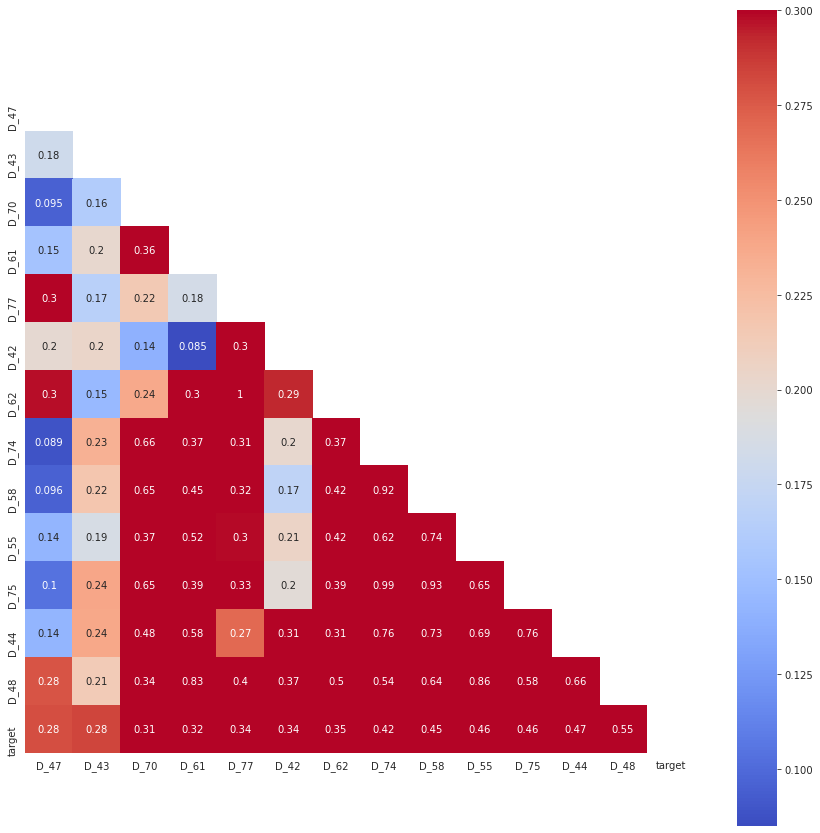

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(cm, mask=mask, vmax=.3, square=True, annot=True, cmap='coolwarm')

# Seleccionamos las features de "gastos" Más relevantes
Nos quedamos con 4 features de 22

In [50]:
Spend_data = train[Spend_columns + ['target']]

In [ ]:
cor_matrix = Spend_data.corr().abs()
print(cor_matrix)

In [63]:
selected_spend_data = Spend_data[['S_7', 'S_15', 'S_20', 'S_25', 'target']]

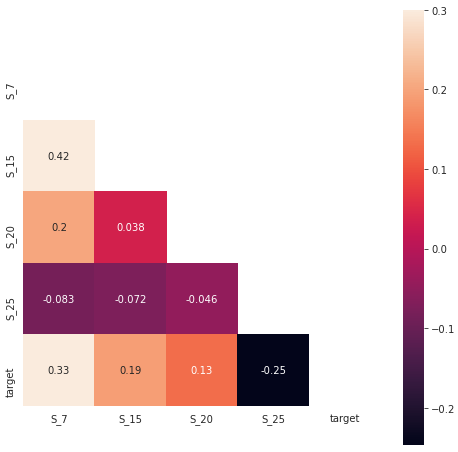

In [64]:
import seaborn as sns
correlaciones_Svars = selected_spend_data.corr()
mask = np.zeros_like(correlaciones_Svars)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(correlaciones_Svars, mask=mask, vmax=.3, square=True, annot=True)

# Seleccionamos las features  de "pagos" relevantes

Nos quedaremos con las 3 variables

In [120]:
pay_data = train[Payment_columns + ['target']]

In [121]:
cm = pay_data.corr().abs()
print(cm)

             P_2       P_3       P_4    target
P_2     1.000000  0.399225  0.278898  0.610765
P_3     0.399225  1.000000  0.104672  0.243743
P_4     0.278898  0.104672  1.000000  0.237511
target  0.610765  0.243743  0.237511  1.000000


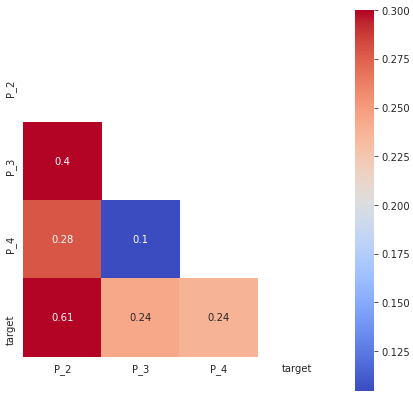

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(cm, mask=mask, vmax=.3, square=True, annot=True, cmap='coolwarm')

# Seleccionamos las features  de "balances" relevantes

Nos quedamos con 10 de 40

In [124]:
balance_data = train[Balance_columns + ['target']] 

In [ ]:
cm = balance_data.corr().abs()
print(cm)

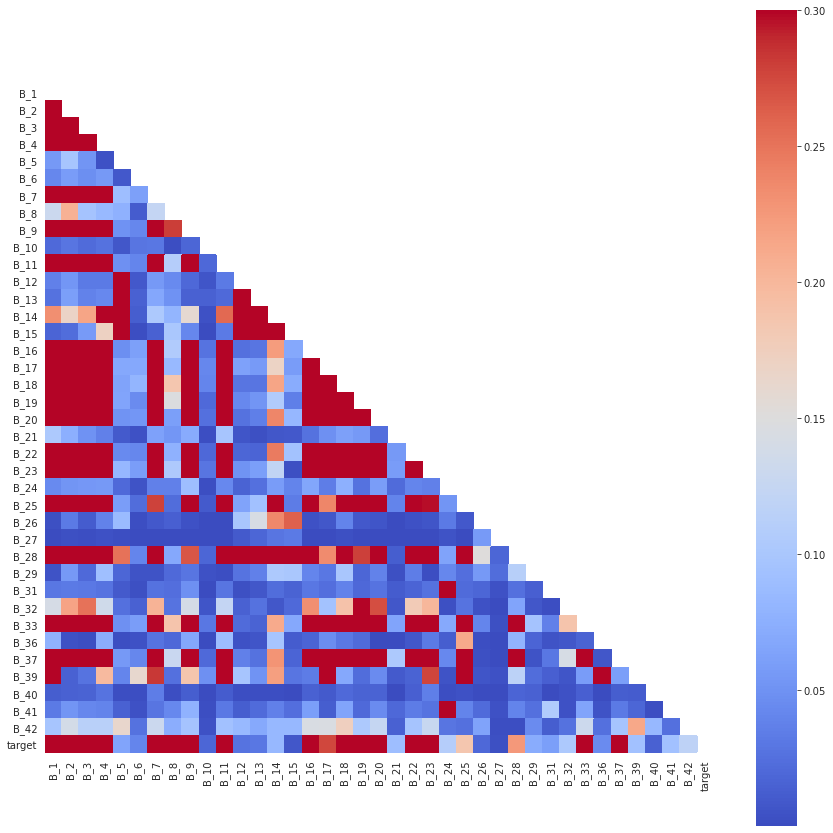

In [128]:
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(cm, mask=mask, vmax=.3, square=True, cmap='coolwarm')

In [138]:
cm.target.sort_values()[-15:-2]

B_22    0.369805
B_20    0.382825
B_37    0.387133
B_19    0.388499
B_1     0.389767
B_16    0.396620
B_4     0.403586
B_23    0.423175
B_3     0.429695
B_7     0.430917
B_33    0.452972
B_9     0.475858
B_2     0.483062
Name: target, dtype: float64

In [160]:
selected_balance_data = balance_data[['B_2', 'B_9', 'B_33', 'B_7', 'B_3', 'B_23', 'B_4', 'B_16', 'B_1',
                                        'B_19', 'B_37', 'B_20', 'B_22', 'target']]

In [157]:
upper_tri = selected_balance_data.where(np.triu(np.ones(selected_balance_data.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.89)]
print(); print(to_drop)


['B_33']


In [161]:
selected_balance_data = selected_balance_data.drop(columns=['B_33', 'B_20', 'B_23', 'B_37'])

In [162]:
cm = selected_balance_data.corr().abs()

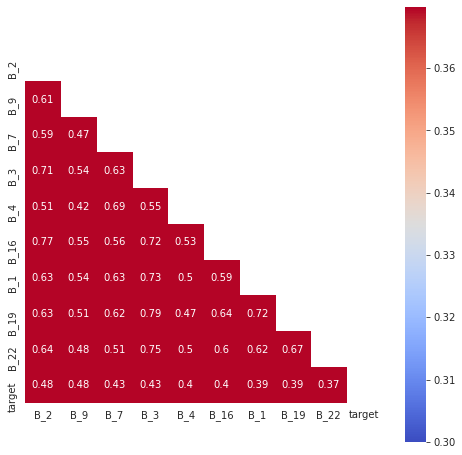

In [164]:
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(cm, mask=mask, vmax=.3, square=True, annot=True, cmap='coolwarm')

# Seleccionamos las features  de "riesgo" relevantes

In [167]:
risk_data = train[Risk_Columns + ['target']]

In [ ]:
cm = risk_data.corr().abs()
print(cm)

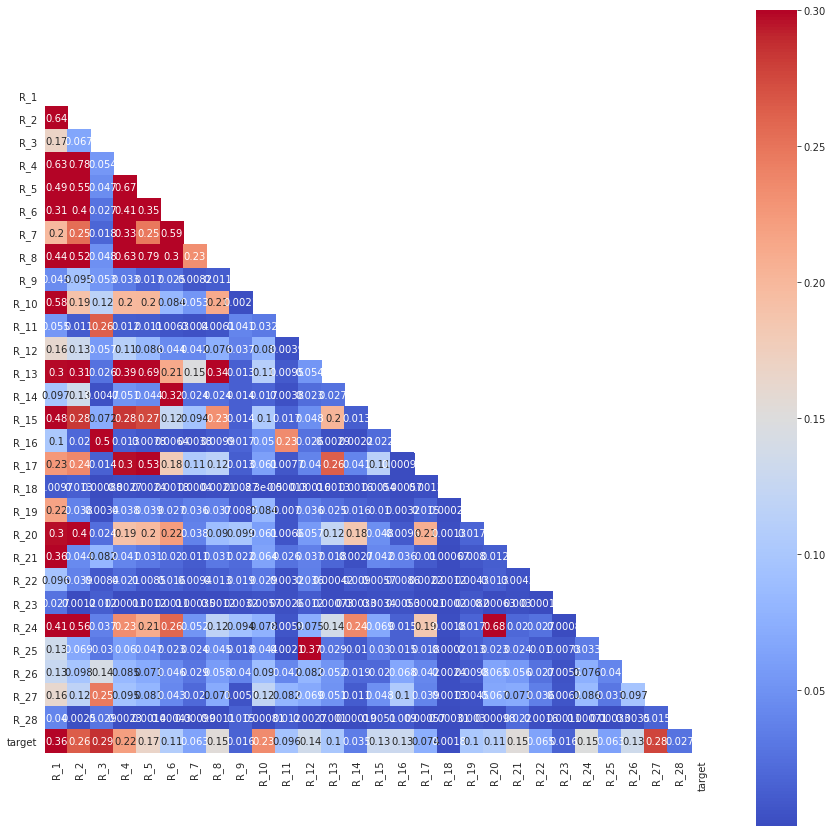

In [169]:
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(cm, mask=mask, vmax=.3, square=True, annot = True, cmap='coolwarm')

In [170]:
cm.target.sort_values()[-15:-2]

R_15    0.129788
R_16    0.130129
R_26    0.134221
R_12    0.135399
R_24    0.149799
R_21    0.153407
R_8     0.154077
R_5     0.167278
R_4     0.221091
R_10    0.234839
R_2     0.263741
R_27    0.277071
R_3     0.286787
Name: target, dtype: float64

In [177]:
selected_risk_data = risk_data[['R_3', 'R_27', 'R_2', 'R_10', 'R_4', 'R_5', 'R_8', 'R_21', 'target']]

In [179]:
upper_tri = selected_risk_data.where(np.triu(np.ones(selected_risk_data.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.89)]
print(); print(to_drop)


['R_27']


In [180]:
cm = selected_risk_data.corr().abs()
print(cm)

             R_3      R_27       R_2      R_10       R_4       R_5       R_8  \
R_3     1.000000  0.246154  0.066792  0.116834  0.054356  0.046527  0.048476   
R_27    0.246154  1.000000  0.117817  0.121105  0.094912  0.081498  0.071142   
R_2     0.066792  0.117817  1.000000  0.189535  0.778281  0.546804  0.517588   
R_10    0.116834  0.121105  0.189535  1.000000  0.199040  0.199836  0.211147   
R_4     0.054356  0.094912  0.778281  0.199040  1.000000  0.672136  0.626703   
R_5     0.046527  0.081498  0.546804  0.199836  0.672136  1.000000  0.791508   
R_8     0.048476  0.071142  0.517588  0.211147  0.626703  0.791508  1.000000   
R_21    0.081862  0.070921  0.043969  0.063841  0.041039  0.030553  0.030722   
target  0.286787  0.277071  0.263741  0.234839  0.221091  0.167278  0.154077   

            R_21    target  
R_3     0.081862  0.286787  
R_27    0.070921  0.277071  
R_2     0.043969  0.263741  
R_10    0.063841  0.234839  
R_4     0.041039  0.221091  
R_5     0.030553  0.16727

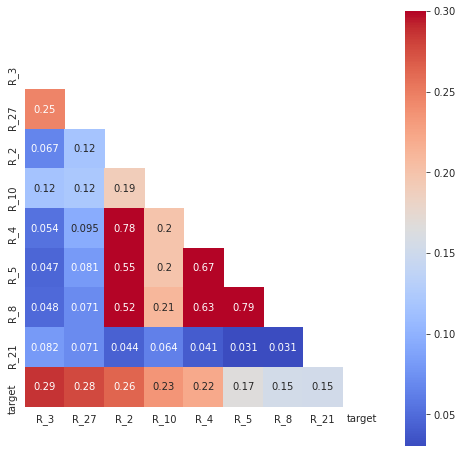

In [181]:
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(cm, mask=mask, vmax=.3, square=True, annot=True, cmap='coolwarm')

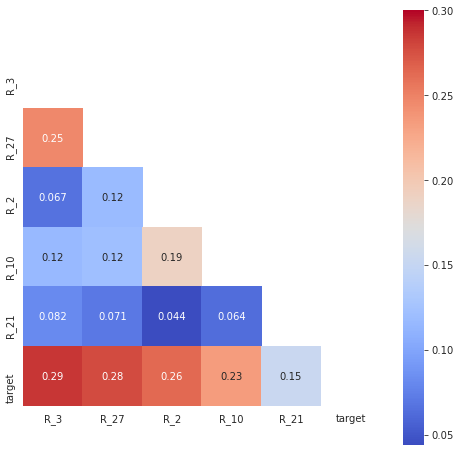

In [182]:
selected_risk_data = selected_risk_data.drop(columns=['R_4', 'R_8', 'R_5'])

cm = selected_risk_data.corr().abs()

mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(cm, mask=mask, vmax=.3, square=True, annot=True, cmap='coolwarm')

# Agrupamos la data seleccionada en un nuevo dataframe

In [199]:
df_init = train[['customer_ID','S_2']]
df_delincuency = selected_d_data.drop(columns=['target'])
df_spend = selected_spend_data.drop(columns=['target'])
df_balance = selected_balance_data.drop(columns=['target'])
df_pay = train[Payment_columns]
df = pd.concat([df_init, df_delincuency, df_spend, df_pay, df_balance, selected_risk_data], axis=1)
df

,customer_ID,S_2,D_47,D_43,D_70,D_61,D_77,D_42,D_62,D_74,...,B_16,B_1,B_19,B_22,R_3,R_27,R_2,R_10,R_21,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.525391,NaN,0.008339,0.308350,NaN,NaN,0.091064,0.080444,...,0.007664,0.008728,0.008522,0.004807,0.001423,1.008789,0.006203,0.007122,0.002449,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.521484,NaN,0.006523,0.265137,NaN,NaN,0.086792,0.081421,...,0.007149,0.004925,0.002237,0.001283,0.001984,1.002930,0.006207,0.005966,0.002247,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.524414,NaN,0.002615,0.212158,NaN,NaN,0.093994,0.078918,...,0.003637,0.021652,0.000408,0.009392,0.007427,1.000977,0.003260,0.005447,0.007793,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.530762,NaN,0.002052,0.204346,NaN,NaN,0.094849,0.077515,...,0.005894,0.013687,0.005898,0.004555,0.003515,1.004883,0.009918,0.001888,0.007687,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.529297,NaN,0.001419,0.175659,NaN,NaN,0.093933,0.076538,...,0.001715,0.015190,0.007774,0.000104,0.001362,1.002930,0.006668,0.006111,0.009659,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.530762,0.014229,0.003292,0.005295,0.305908,NaN,0.324951,0.009697,...,0.835938,0.020813,0.003550,0.002443,0.002056,1.009766,0.002472,0.006989,0.002718,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.534668,0.009468,0.004383,0.018173,0.303223,NaN,0.328613,0.007172,...,0.754883,0.007210,0.001557,0.005238,0.002460,1.007812,0.008720,0.005150,0.002911,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.530273,0.006592,0.006802,0.013031,0.300293,NaN,0.328857,0.006229,...,0.757812,0.013153,0.000679,0.006931,0.009697,1.003906,0.008369,0.006420,0.000365,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.531250,0.014236,0.004192,0.032196,0.305420,NaN,0.330811,0.004906,...,0.671875,0.009857,0.002403,0.005150,0.005722,1.001953,0.004704,0.000041,0.007687,0


In [200]:
df.columns

Index(['customer_ID', 'S_2', 'D_47', 'D_43', 'D_70', 'D_61', 'D_77', 'D_42',
       'D_62', 'D_74', 'D_58', 'D_55', 'D_75', 'D_44', 'D_48', 'S_7', 'S_15',
       'S_20', 'S_25', 'P_2', 'P_3', 'P_4', 'B_2', 'B_9', 'B_7', 'B_3', 'B_4',
       'B_16', 'B_1', 'B_19', 'B_22', 'R_3', 'R_27', 'R_2', 'R_10', 'R_21',
       'target'],
      dtype='object')

In [202]:
cm = df.corr().abs()

mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(cm, mask=mask, vmax=.3, square=True, annot=True, cmap='coolwarm')

In [ ]:
cm.target.sort_values()[-15:-2]

In [ ]:
upper_tri = df.where(np.triu(np.ones(df.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.89)]
print(); print(to_drop)